In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

import cv2
from scipy import ndimage

In [2]:
all_npz = glob('../data_with_centers/*.npz')
print(all_npz)

alldata = []
for file in all_npz:
    with np.load(file) as data:
        alldata.append({'old_filename': data['old_filename'], 'biosensor': data['biosensor'], 'mask': data['mask'], 'cell_centers': data['cell_centers']})

alldata.sort(key=lambda x: x['old_filename'])

['../data_with_centers\\0.npz', '../data_with_centers\\1.npz', '../data_with_centers\\10.npz', '../data_with_centers\\100.npz', '../data_with_centers\\101.npz', '../data_with_centers\\102.npz', '../data_with_centers\\103.npz', '../data_with_centers\\104.npz', '../data_with_centers\\105.npz', '../data_with_centers\\106.npz', '../data_with_centers\\107.npz', '../data_with_centers\\108.npz', '../data_with_centers\\109.npz', '../data_with_centers\\11.npz', '../data_with_centers\\110.npz', '../data_with_centers\\111.npz', '../data_with_centers\\112.npz', '../data_with_centers\\113.npz', '../data_with_centers\\114.npz', '../data_with_centers\\115.npz', '../data_with_centers\\116.npz', '../data_with_centers\\117.npz', '../data_with_centers\\118.npz', '../data_with_centers\\119.npz', '../data_with_centers\\12.npz', '../data_with_centers\\120.npz', '../data_with_centers\\121.npz', '../data_with_centers\\122.npz', '../data_with_centers\\123.npz', '../data_with_centers\\124.npz', '../data_with_ce

In [3]:
# Sorted by filename
for data in alldata:
    print(data['old_filename'] , data['biosensor'].shape, data['mask'].shape, len(data['cell_centers']))

fibronectin\20200722_Preo_Hela_fn\A4_seg.npz (717, 80, 80) (4159, 4159) 85
fibronectin\20200722_Preo_Hela_fn\B4_seg.npz (717, 80, 80) (4253, 4253) 405
fibronectin\20200722_Preo_Hela_fn\C4_seg.npz (717, 80, 80) (4179, 4179) 300
fibronectin\20200729_Preo_Hela_fn\B4_seg.npz (1189, 80, 80) (4204, 4204) 461
fibronectin\20200729_Preo_Hela_fn\C4_seg.npz (1189, 80, 80) (4235, 4235) 248
fibronectin\20210526_LCLC_fn\A1_seg.npz (1140, 80, 80) (4190, 4190) 55
fibronectin\20210526_LCLC_fn\A2_seg.npz (1140, 80, 80) (4169, 4169) 36
fibronectin\20210526_LCLC_fn\A3_seg.npz (1140, 80, 80) (4223, 4223) 51
fibronectin\20210526_LCLC_fn\A4_seg.npz (1140, 80, 80) (4234, 4234) 39
fibronectin\20210526_LCLC_fn\B1_seg.npz (1140, 80, 80) (4159, 4159) 50
fibronectin\20210526_LCLC_fn\B2_seg.npz (1140, 80, 80) (4210, 4210) 47
fibronectin\20210526_LCLC_fn\B3_seg.npz (1140, 80, 80) (4154, 4154) 47
fibronectin\20210526_LCLC_fn\B4_seg.npz (1140, 80, 80) (4201, 4201) 41
fibronectin\20210526_LCLC_fn\C1_seg.npz (1140, 80, 

In [10]:
print(alldata[90]['old_filename'])

noncoated\20210407_LCLC_H838_nonc\A1_seg.npz


In [ ]:
def __getitem__(self, index):
    data = np.load(self.path + self.files[index])
    bio = self.uniform_time_dim(torch.from_numpy(data['biosensor'].astype(np.float32)))
    mask = self.uniform_mask(torch.from_numpy(data['mask'].astype(self.mask_type)), data['cell_centers'])
    bio = self.normalize(bio)
    if self.transform:
        mask = tv_tensors.Mask(mask)
        bio, mask = self.transform(bio, mask)
    return bio, mask

def uniform_time_dim(self, biosensor):
    indices = np.linspace(0, biosensor.shape[0] - 1, self.length, dtype=int)
    return biosensor[indices]


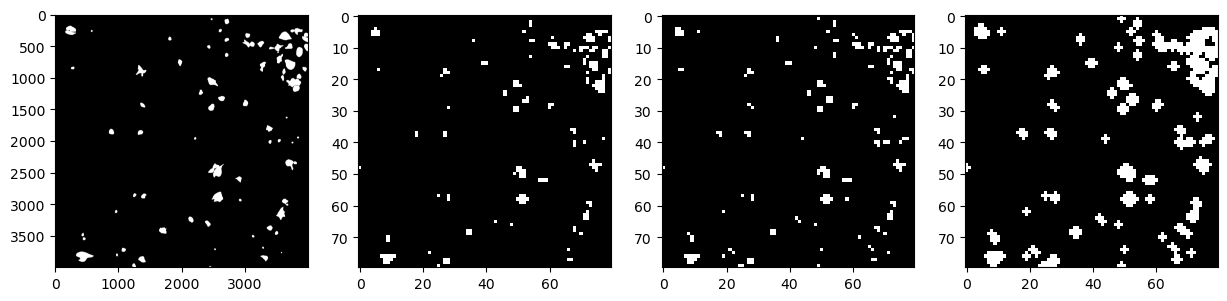

In [6]:
def uniform_4000(mask, centers):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(4000,4000), mode='nearest').squeeze(0).squeeze(0).byte()
    return interpolated_mask

def uniform_80(mask, centers):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(80, 80), mode='nearest').squeeze(0).squeeze(0).byte()
    return interpolated_mask

def uniform_80_centers(mask, centers):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(80, 80), mode='nearest').squeeze(0).squeeze(0).byte()
    
    x_scale = mask.shape[0] / 80
    y_scale = mask.shape[1] / 80
    
    scaled_centers = centers / [x_scale, y_scale]

    indices = np.transpose(scaled_centers.astype(int))
    interpolated_mask[indices[0], indices[1]] = True

    return interpolated_mask

data = alldata[0]

fig, axs = plt.subplots(1, 4, figsize=(15, 20))

axs[0].imshow(uniform_4000(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers']), cmap='gray')
axs[1].imshow(uniform_80(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers']), cmap='gray')
axs[2].imshow(uniform_80_centers(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers']), cmap='gray')
axs[3].imshow(ndimage.binary_dilation(uniform_80_centers(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])), cmap='gray')

plt.show()

(4186, 4186)
52.325 52.325


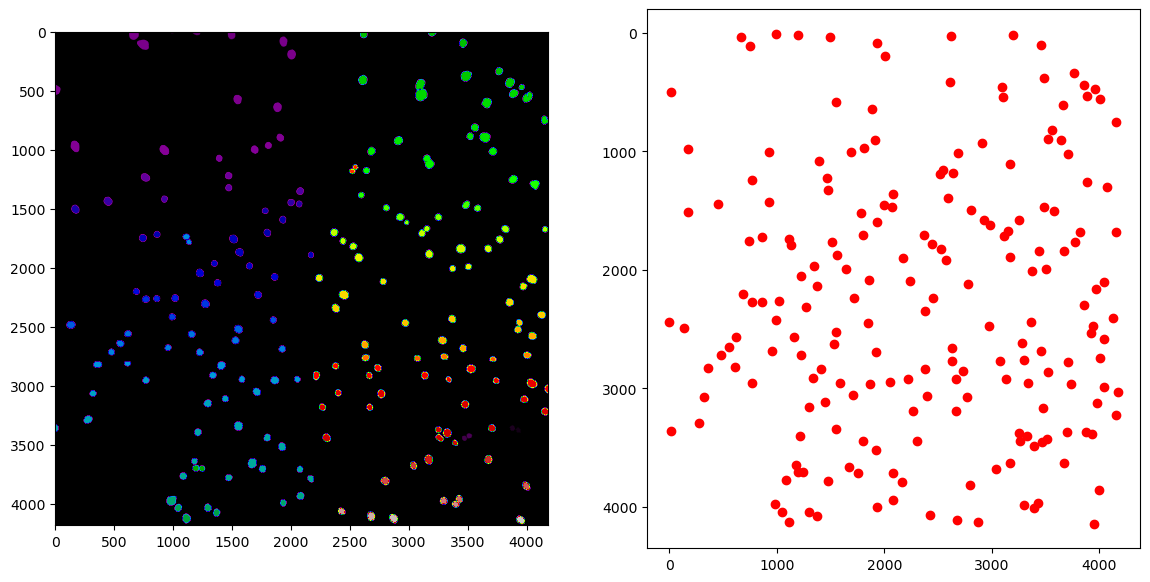

In [17]:
test = alldata[90]
test_mask = test['mask'].astype(np.uint8)
test_centers = test['cell_centers']
test_mask_tensor = torch.from_numpy(test_mask)

mask_size = 80

x, y = zip(*test_centers)
ig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].imshow(test_mask, cmap='nipy_spectral')

# Raw np calculation
axs[1].scatter(y, x, c='red')
axs[1].invert_yaxis()

print(test_mask.shape)
x_scale = test_mask.shape[0] / mask_size
y_scale = test_mask.shape[1] / mask_size
print(x_scale, y_scale)
scaled_centers = test_centers / [x_scale, y_scale]
# scaled_centers = scaled_centers.astype(int)
# print(scaled_centers)
interpolated_mask = torch.nn.functional.interpolate(test_mask_tensor.unsqueeze(0).unsqueeze(0).float(), size=(mask_size, mask_size), mode='nearest').squeeze(0).squeeze(0).byte()


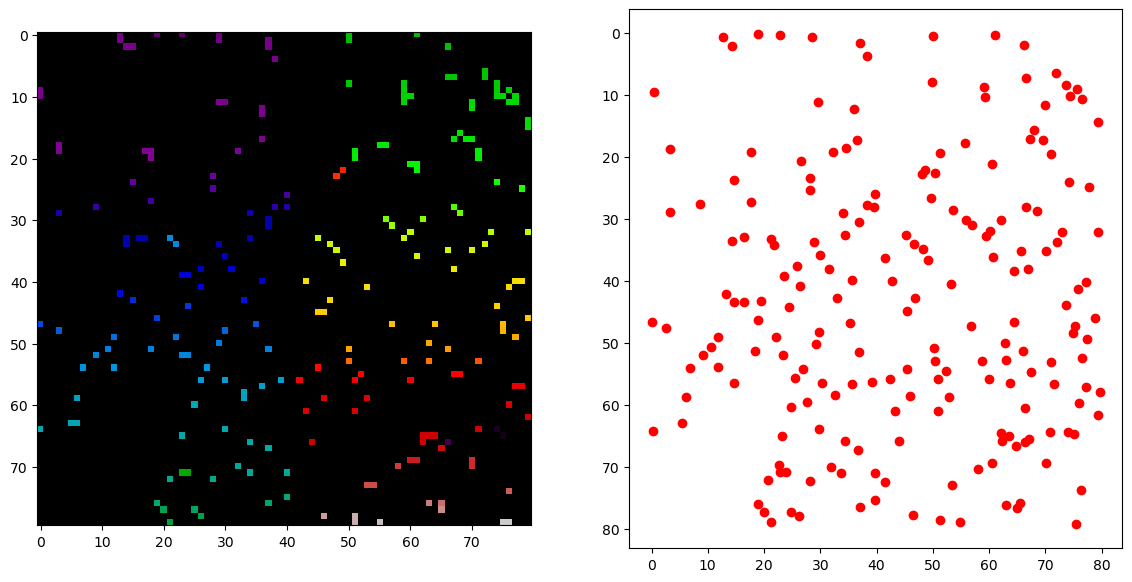

In [12]:
y = [point[0] for point in scaled_centers]
x = [point[1] for point in scaled_centers]

# create a 2D plot
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# plot the mask
axs[0].imshow(interpolated_mask, cmap='nipy_spectral')

# plot the centers on the mask
# axs[0].scatter(x, y, c='red')

# Raw np calculation
axs[1].scatter(x, y, c='red')
axs[1].invert_yaxis()

# show the plot
plt.show()

In [58]:
# assuming interpolated_mask is your mask and it's a numpy array
# and scaled_centers are your centers

for point in scaled_centers:
    y, x = point
    # set the corresponding pixel in the mask to 255 (or any other value you want)
    interpolated_mask[int(y), int(x)] = 255

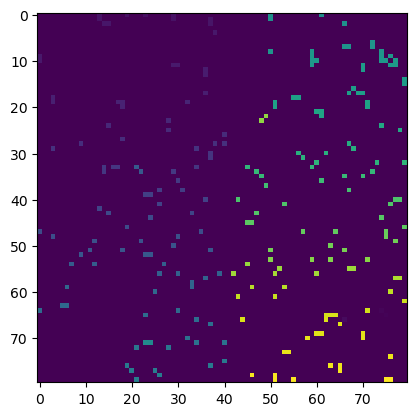

In [13]:
plt.imshow(interpolated_mask)

In [38]:
print(has_duplicate_arrays(scaled_centers))

False


In [37]:
def has_duplicate_arrays(arr_list):
    byte_arrays = [arr.tobytes() for arr in arr_list]
    return len(byte_arrays) != len(set(byte_arrays))

In [ ]:
plt.figure(figsize=(50, 50))
plt.imshow(test_mask)
plt.show()

[ 0  2  3  4  6  7  8  9 10 11 12 14 15 16 17 18 20 21 23 31 32 35 36 37
 38 39 40 45 46 48 49 50 51 54 56 57 60]


(37,)

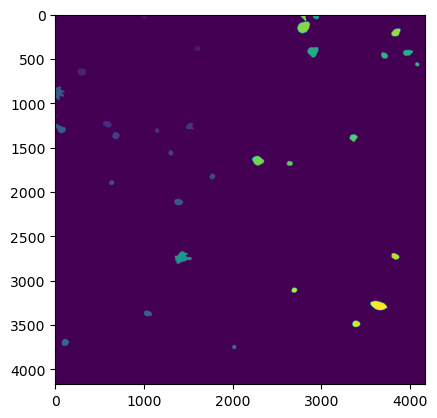

In [20]:
test_mask = masks[6]

# Nincs annyi sejt a maszkon ahány számmal jelöltük
plt.imshow(test_mask)
print(np.unique(test_mask))
np.unique(test_mask).shape

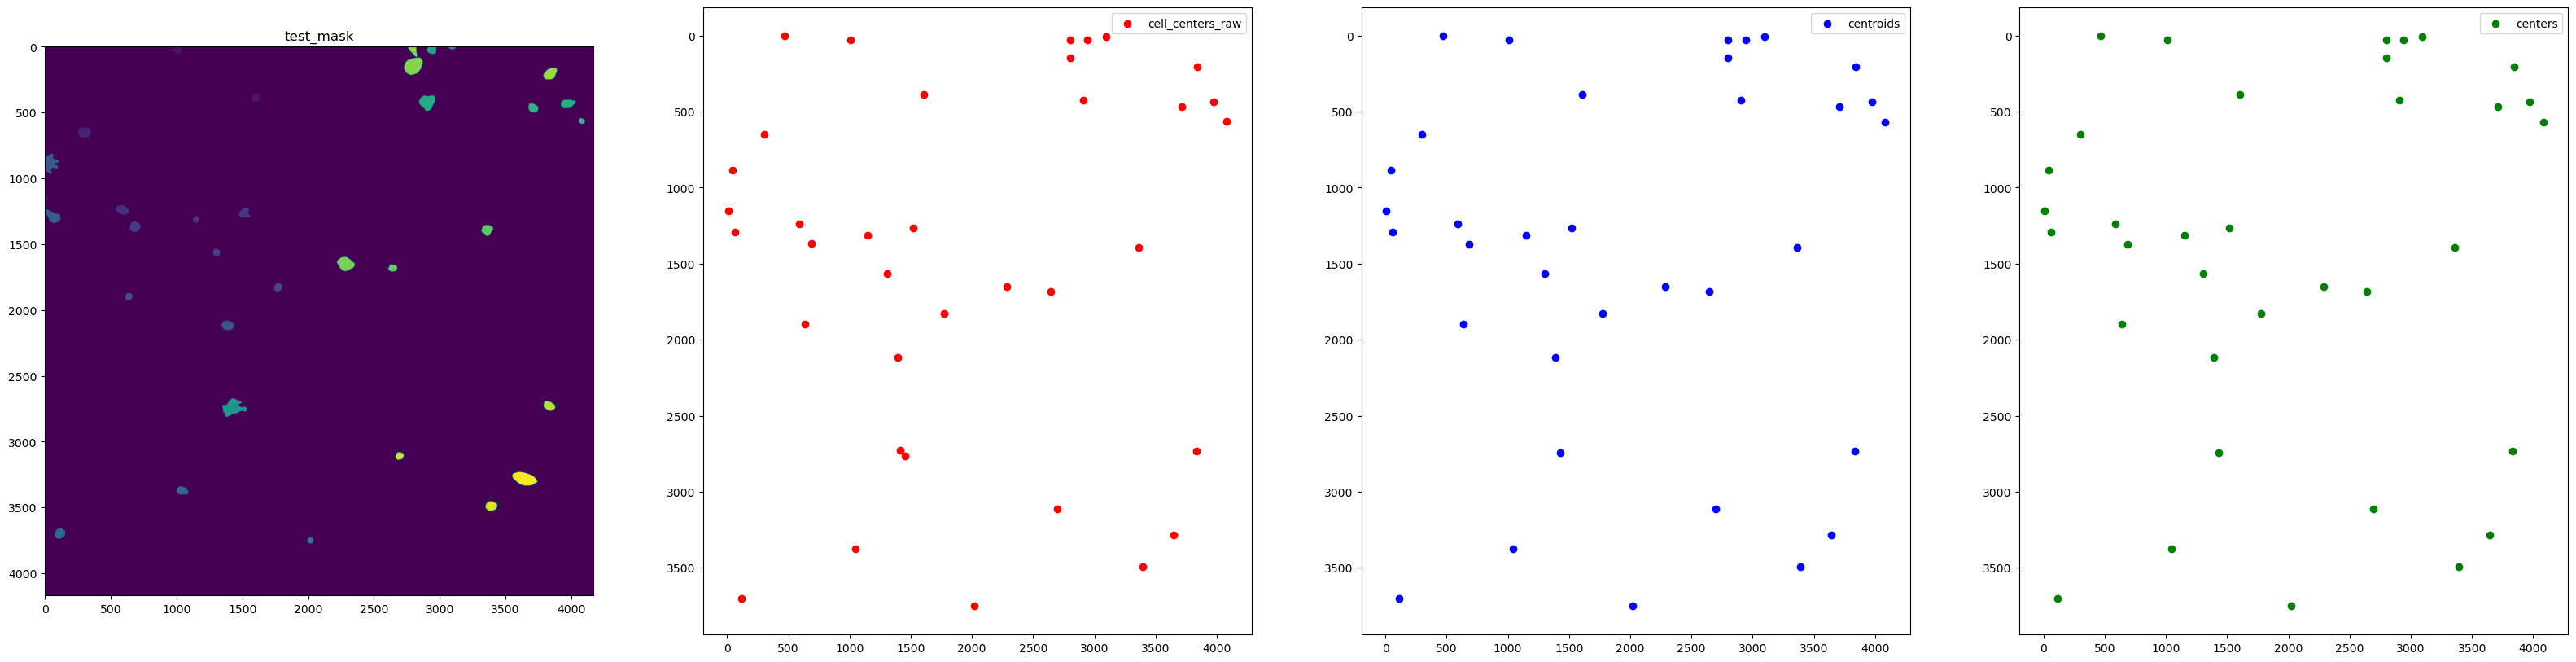

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(40, 10))

# Plot the test_mask
axs[0].imshow(test_mask)
axs[0].set_title('test_mask')

# Create a scatter plot for cell_centers_raw
axs[1].scatter(cell_centers_raw_y, cell_centers_raw_x, c='red', label='cell_centers_raw')
axs[1].invert_yaxis()
axs[1].legend()

# Create a scatter plot for centroids
axs[2].scatter(centroids_x, centroids_y, c='blue', label='centroids')
axs[2].invert_yaxis()  # Invert the y-axis
axs[2].legend()

# Create a scatter plot for centers
axs[3].scatter(centers_y, centers_x, c='green', label='centers')
axs[3].invert_yaxis()
axs[3].legend()

plt.show()